In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from utils.data_utils import DataLoader
import random

/home/hs/anaconda3/envs/tf28/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cfg = {}
cfg['data'] = {}
cfg['data']['name'] = 'custom'
cfg['data']['labels'] = {}
cfg['data']['labels']['name'] = ['Nam Joo-hyuk', 'Kim Da-mi', 'Kim Seong-cheol', 
                                 'Yoo Jae-suk', 'Kim Tae-ri', 'Choi Woo-shik']
# cfg['data']['labels']['name']=['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
#        'bus', 'car', 'cat', 'chair', 'cow', 
#        'diningtable', 'dog', 'horse', 'motorbike', 'person', 
#        'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
cfg['batch_size'] = 4
cfg['model'] = {}
cfg['model']['anchors'] = np.zeros((3,3,2))
cfg['data']['labels']['count'] = 6
cfg['model']['input_size'] = np.array([512, 512])
cfg['seed'] = 42
cfg['data']['max_bboxes'] = 100
cfg['aug'] = {'mosaic':4, 'random_scale':1.0, 'random_rotate90':0.75,
              'random_flip_horizontal':0.5, 'random_crop':1.0,
              'random_gaussian_blur':0.3, 'random_brightness':0.5,
              'random_hue':0.5, 'random_satuation':0.5, 'random_contrast':0.5}
cfg['batch_size'] *= cfg['aug']['mosaic']

In [16]:
dataloader = DataLoader(cfg)
train_dataset = dataloader('train', 4, aug=cfg['aug'])
val_dataset = dataloader('val')

data = []
for e in range(3):
    for i, (batch_images, batch_labels) in enumerate(train_dataset):
        if i==0:
            data += [[batch_images,batch_labels]]
        


Dataset: custom train
./data/custom/train.tfrecord is exist
Dataset: custom val
./data/custom/val.tfrecord is exist


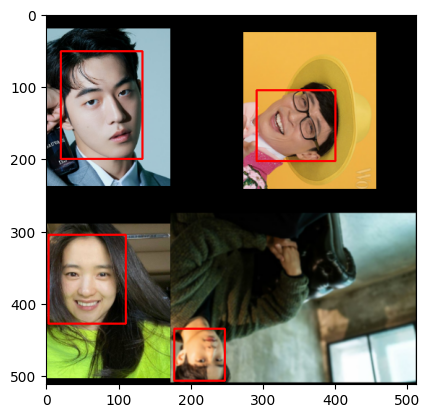

In [22]:
b=2
idx = 0
image =(data[b][0][idx].numpy()*255).astype(np.uint8)
labels = data[b][1]
labels = labels[labels[..., 0] == idx].numpy().astype(np.int32)

for i, x1, y1, x2, y2, c in labels:
    cv2.rectangle(image, [x1,y1], [x2,y2], [255, 0, 0], 2)
plt.imshow(image)
plt.show() 

In [15]:
def resize_padding(image, labels, out_size, random=False, mode='CONSTANT', constant_values=0, seed=42):
    size = tf.cast(tf.shape(image)[-2:-4:-1], tf.float32)

    large = max(size/out_size)
    ratio = min(large, 1/large)
    new_size = tf.cast(ratio * size, tf.int32)
    
    pad_size = out_size - tf.cast(new_size, tf.float32)
    pad_ratio = tf.random.uniform((), 0, 1, seed=seed) if random else 0.5
    pad_LT = tf.cast(pad_size*pad_ratio, tf.int32)
    pad_RB = tf.cast(pad_size, tf.int32) - pad_LT
    pad_left, pad_top = tf.unstack(pad_LT)
    pad_right, pad_bottom = tf.unstack(pad_RB)
    padding = tf.reshape(tf.stack([pad_top, pad_bottom, pad_left, pad_right, 0, 0]), [3, 2])

    resized_image = tf.image.resize(image, new_size[::-1])
    padded_image = tf.pad(resized_image, padding, mode=mode, constant_values=constant_values)
    resized_labels = tf.round(tf.concat([labels[..., 0:1] * ratio + float(pad_left),
                                         labels[..., 1:2] * ratio + float(pad_top),
                                         labels[..., 2:3] * ratio + float(pad_left),
                                         labels[..., 3:4] * ratio + float(pad_top),
                                         labels[..., 4:]], -1))
    return padded_image, resized_labels

tf.Tensor(
[[128. 128. 384. 384.   0.]
 [102. 102. 410. 410.   1.]], shape=(2, 5), dtype=float32)


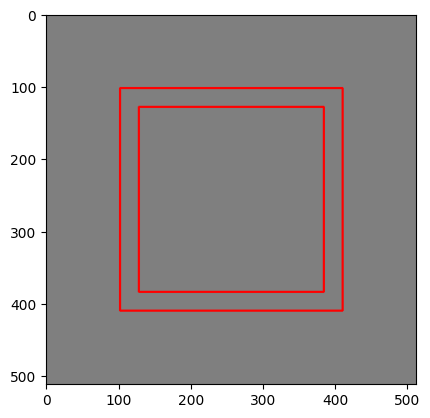

In [19]:
a=tf.zeros((512,512,3))+0.5
t=512/4
t2=512/5
box = tf.constant([[t,t,t*3,t*3, 0.],[t2,t2,t2*4,t2*4,1.]])
image, label = resize_padding(a, box, tf.stack([512., 512.]), True, seed=42)
print(label)
i = (image.numpy()*255).astype(np.uint8)
label = label.numpy().astype(np.int32)
for x1, y1, x2, y2, c in label:
    cv2.rectangle(i, [x1,y1], [x2, y2], [255, 0, 0], 2)
plt.imshow(i)
plt.show()


In [23]:
box + [10,20,10,20, 0], box

(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[138. , 148. , 394. , 404. ,   0. ],
        [112.4, 122.4, 419.6, 429.6,   1. ]], dtype=float32)>,
 <tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[128. , 128. , 384. , 384. ,   0. ],
        [102.4, 102.4, 409.6, 409.6,   1. ]], dtype=float32)>)

In [144]:
for batch_images, batch_labels in train_dataset:
    break

In [180]:
size = 4
s = np.sqrt(size).astype(np.int32)
input_size = dataloader.input_size
image_size = input_size.astype(np.int32)
mosaic_image = np.zeros([*(input_size.astype(np.int32) * s), 3])
indices = tf.random.uniform([size], minval=0, maxval=dataloader.batch_size, dtype=tf.int32)

for i, index in enumerate(indices):
    mosaic_image[image_size[0]*(i//s):image_size[0]*(i//s+1), image_size[1]*(i%s):image_size[1]*(i%s+1)] = batch_images[index]


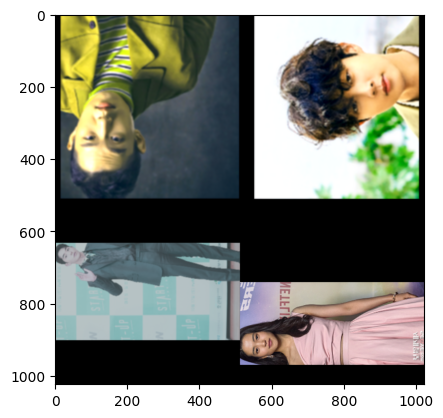

In [181]:
plt.imshow(mosaic_image)
plt.show()

In [3]:
import tensorflow as tf

# 예제 데이터 생성
data = [[tf.zeros([10,10,3]), tf.zeros([i,4])] for i in range(2,8)]

# 배치 크기
batch_size = 3

# 배치를 생성하는 함수
def create_custom_batch(dataset, batch_size):
    batch = []
    batch2 = []
    idx = 0
    for item1, item2 in dataset:
        batch.append(item1)
        batch2 += [tf.concat([tf.zeros(item2.shape[:-1], dtype=tf.float32)[..., None]+idx, item2], -1)]
        idx += 1
        if len(batch) == batch_size:
            yield batch, tf.concat(batch2, 0)
            batch = []
            batch2 = []
            idx = 0
    if batch:  # 마지막에 남은 데이터 처리
        yield batch, tf.concat(batch2, 0)

# 사용자 정의 배치 생성
custom_batch_dataset = tf.data.Dataset.from_generator(
    lambda: create_custom_batch(data, batch_size),
    output_signature=(tf.TensorSpec(shape=[None, None,None,None], dtype=tf.float32),
                      tf.TensorSpec(shape=[None, None], dtype=tf.float32))
)

# 결과 확인
for i in range(2):
    for batch, batch2 in custom_batch_dataset:
        print(batch.shape, batch2.shape)


(3, 10, 10, 3) (9, 5)
(3, 10, 10, 3) (18, 5)
(3, 10, 10, 3) (9, 5)
(3, 10, 10, 3) (18, 5)


In [9]:
import tensorflow as tf
import numpy as np

# 데이터셋 생성 (임의의 예시)
data = np.random.rand(100, 2)  # 100개의 2차원 데이터 포인트 생성
labels = np.random.randint(0, 2, size=(100,))  # 0 또는 1의 레이블 생성

# 데이터셋 만들기
dataset = tf.data.Dataset.from_tensor_slices((data, labels))

# 사용자 지정 배치 크기
batch_size = 5

# 배치 생성 함수 정의
def create_custom_batches(dataset):
    batch_data = []
    batch_labels = []
    for item in dataset:
        batch_data.append(item[0])
        batch_labels.append(item[1])
        if len(batch_data) == batch_size:
            yield (tf.stack(batch_data), tf.convert_to_tensor(batch_labels))
            batch_data = []
            batch_labels = []

# 사용자 지정 배치 데이터셋 생성
custom_batch_dataset = tf.data.Dataset.from_generator(lambda: create_custom_batches(dataset), 
                                                      output_signature=(tf.TensorSpec(shape=(batch_size, 2), dtype=tf.float64), 
                                                                        tf.TensorSpec(shape=(batch_size,), dtype=tf.int32)))

# 데이터셋 확인
data=[]
for e in range(3):
    for i, (batch_data, batch_labels) in enumerate(custom_batch_dataset):
        if i==0:
            data += [batch_data]
data


[<tf.Tensor: shape=(5, 2), dtype=float64, numpy=
 array([[0.93565278, 0.85155761],
        [0.80673058, 0.91212716],
        [0.27587628, 0.6071321 ],
        [0.15456139, 0.7566546 ],
        [0.45105058, 0.56575879]])>,
 <tf.Tensor: shape=(5, 2), dtype=float64, numpy=
 array([[0.93565278, 0.85155761],
        [0.80673058, 0.91212716],
        [0.27587628, 0.6071321 ],
        [0.15456139, 0.7566546 ],
        [0.45105058, 0.56575879]])>,
 <tf.Tensor: shape=(5, 2), dtype=float64, numpy=
 array([[0.93565278, 0.85155761],
        [0.80673058, 0.91212716],
        [0.27587628, 0.6071321 ],
        [0.15456139, 0.7566546 ],
        [0.45105058, 0.56575879]])>]

In [5]:
tf.data.Dataset.from_tensor_slices(data)

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [10,10,3] != values[1].shape = [2,4] [Op:Pack] name: 0

In [6]:
tf.data.Dataset.take_while

[<tf.Tensor: shape=(10, 10, 3), dtype=float32, numpy=
 array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 

In [7]:
import numpy as np

In [13]:
a=np.array(1.)
float(a)

1.0

In [6]:
import numpy as np

In [11]:
size = a.shape[:2]
size

(5, 6)

In [4]:
size=[20,20]
xc = 7
s = 2
for i in range(4):
    if i//2==0:
        print(xc)
    else:
        print(size[0]-xc)

7
7
13
13


In [6]:
for i in range(4):
    # print(size[0]*(i//2)-xc*(i//2+1)+xc*(s-i//2))
    print(size[0]*(i%2) - xc*(i%s*s + 1 - s))

7
13
7
13


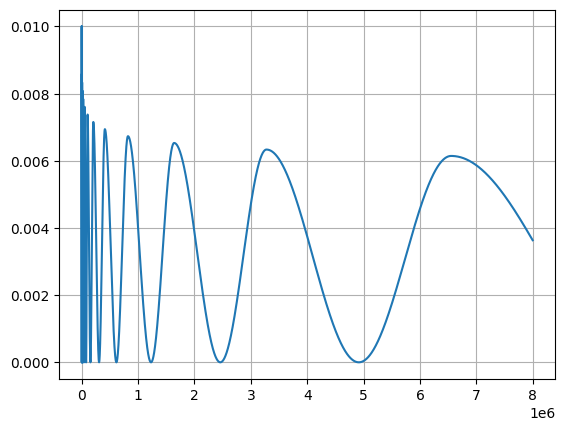

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
from utils.lr_shcedulers import LR_scheduler

with open('yaml/config.yaml') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
cfg['train']['lr_scheduler']['name'] = 'custom'
cfg['train']['lr_scheduler']['warmup_epochs']=0

epochs=2000
step_per_epoch = 4000
lr_scheduler = LR_scheduler(cfg['train']['lr_scheduler'], epochs, step_per_epoch)

steps = []
lrs = []
t = []
for epoch in range(1, epochs+1):
    for step in range((epoch-1)*step_per_epoch+1, epoch*step_per_epoch+1):
        steps += [step]
        lrs += [lr_scheduler(step)]
        t += [lr_scheduler.lr_scheduler.t_max]

plt.plot(steps, lrs)
plt.grid(True)

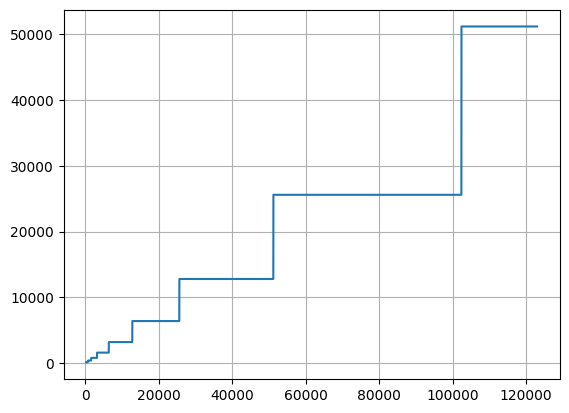

In [2]:
plt.plot(steps, t)
plt.grid(True)

In [15]:
lrs[-1]

4.99999999999945e-06

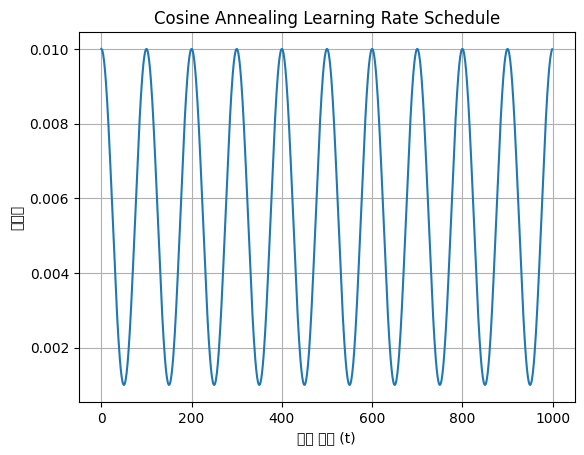

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def cosine_annealing(t, min_lr, max_lr, t_max):
    return min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(t / t_max * np.pi))

t_values = np.arange(0, 1000, 1)  # 학습 단계는 0부터 99까지
min_lr = 0.001  # 최소 학습률
max_lr = 0.01   # 최대 학습률
t_max = 50      # 주기

lr_values = cosine_annealing(t_values, min_lr, max_lr, t_max)

plt.plot(t_values, lr_values)
plt.xlabel('학습 단계 (t)')
plt.ylabel('학습률')
plt.title('Cosine Annealing Learning Rate Schedule')
plt.grid(True)
plt.show()


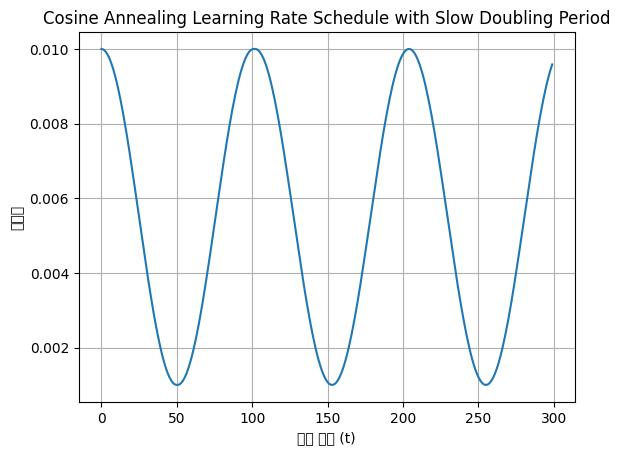

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def cosine_annealing(t, min_lr, max_lr, t_max):
    return min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(t / t_max * np.pi))

t_values = np.arange(0, 300, 1)  # 학습 단계는 0부터 99까지
min_lr = 0.001  # 최소 학습률
max_lr = 0.01   # 최대 학습률
t_max = 50      # 초기 주기
t_max_increment = 0.01  # 주기 증가량

lr_values = []
for t in t_values:
    lr_values.append(cosine_annealing(t, min_lr, max_lr, t_max))
    if t % t_max == 0 and t != 0:
        t_max += t_max * t_max_increment  # 주기를 조금씩 증가시킴

plt.plot(t_values, lr_values)
plt.xlabel('학습 단계 (t)')
plt.ylabel('학습률')
plt.title('Cosine Annealing Learning Rate Schedule with Slow Doubling Period')
plt.grid(True)
plt.show()


In [3]:
# single gpu, multi gpu 통합

60